In [212]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [213]:
np.random.seed(42)
random.seed(42)

In [214]:
sagemaker_session = sagemaker.Session()

In [215]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = "deepar-electricity-demo-notebook"  # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [216]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [217]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [218]:
# DATA_HOST = f"sagemaker-example-files-prod-{region}"
# DATA_PATH = "datasets/timeseries/uci_electricity/"
# ARCHIVE_NAME = "LD2011_2014.txt.zip"
# FILE_NAME = ARCHIVE_NAME[:-4]

In [219]:
# s3_client = boto3.client("s3")

# if not os.path.isfile(FILE_NAME):
#     print("downloading dataset (258MB), can take a few minutes depending on your connection")
#     s3_client.download_file(DATA_HOST, DATA_PATH + ARCHIVE_NAME, ARCHIVE_NAME)

#     print("\nextracting data archive")
#     zip_ref = zipfile.ZipFile(ARCHIVE_NAME, "r")
#     zip_ref.extractall("./")
#     zip_ref.close()
# else:
#     print("File found skipping download")

In [220]:
# data = pd.read_csv(FILE_NAME, sep=";", index_col=0, parse_dates=True, decimal=",")
# num_timeseries = data.shape[1]
# data_kw = data.resample("2H").sum() / 8
# timeseries = []
# for i in range(num_timeseries):
#     timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

In [221]:
# num_timeseries

In [222]:
# data_kw.index

In [223]:
data1= pd.read_excel('electricity_og_data.xlsx')

In [224]:
#data1 = data1.drop(columns = ['Unnamed: 0'], axis = 1)
cluster = data1.groupby('Cluster').mean()
cluster = cluster.T

In [225]:
cluster.index = pd.to_datetime(cluster.index)


In [226]:
cluster = cluster[:-1]

In [227]:
num_timeseries1 = cluster.shape[1]
timeseries1 = []
cluster = cluster.resample("D").mean()
for i in range(num_timeseries1):
    timeseries1.append(cluster.iloc[:, i])

In [228]:
timeseries1[1]

2011-01-01    14003.369253
2011-01-02    15521.992337
2011-01-03     9429.944923
2011-01-04     9252.559866
2011-01-05     9463.273467
                  ...     
2014-12-27     3722.837644
2014-12-28     5168.000479
2014-12-29     6348.987069
2014-12-30     5123.472222
2014-12-31     4215.426245
Freq: D, Name: 2, Length: 1461, dtype: float64

In [229]:
len(timeseries1)

14

----------------------------------------

In [230]:
weather = pd.read_csv('daily_temperature.csv',  sep=';', decimal=',')
weather = weather[:-1]
weather.rename(columns={"[": "text"}, inplace = True)
weather = weather.astype("string")
for i in range(1, len(weather.text)):
    weather.text[i]= weather.text[i].replace(',','',1)
    
df = []
for i in range(len(weather.text)):
    data=eval(weather.text[i])
    d = pd.DataFrame(data,index=[i])
    df.append(d)
    
for i in range(len(df)):
    if 'TAVG' not in df[i].columns:
        df[i]['TAVG'] = (float(df[i]['TMAX']) + float(df[i]['TMIN']))/2

w = pd.concat(df)
w.set_index('DATE', inplace = True)
w = w.drop(columns = ['STATION'], axis = 1)

In [231]:
w.index = pd.to_datetime(w.index)

In [232]:
w = w.resample("D").mean()

In [233]:
w.head()

,TMAX,TAVG,TMIN,PRCP
DATE,,,,
2011-01-01,63.0,57.0,52.0,0.02
2011-01-02,54.0,51.0,49.0,0.00
2011-01-03,56.0,52.0,49.0,0.00
2011-01-04,60.0,56.0,50.0,0.02
2011-01-05,62.0,60.0,58.0,1.23


In [234]:
w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2011-01-01 to 2016-01-01
Freq: D
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    1827 non-null   float64
 1   TAVG    1827 non-null   float64
 2   TMIN    1827 non-null   float64
 3   PRCP    1827 non-null   float64
dtypes: float64(4)
memory usage: 71.4 KB


----------------------------------

In [235]:
freq = "D"

# we predict for 7*4*3 days
prediction_length = 7 * 4 * 3

# we also use 7*4*3 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 4 * 3

In [236]:
start_dataset = pd.Timestamp("2011-01-01", freq=freq)
end_training = pd.Timestamp("2014-01-01", freq=freq)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  


In [237]:
# training_data = [
#     {
#         "start": str(start_dataset),
#         "target": ts[
#             start_dataset : end_training - timedelta(days=1)
#         ].tolist(),# We use -1, because pandas indexing includes the upper bound
#     }
#     for ts in timeseries1
# ]
# print(len(training_data))

In [238]:
# num_test_windows = 4

# test_data = [
#     {
#         "start": str(start_dataset),
#         "target": ts[start_dataset : end_training + timedelta(days=k * prediction_length)].tolist(),
#     }
#     for k in range(1, num_test_windows + 1)
#     for ts in timeseries1
# ]
# print(len(test_data))

In [239]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [240]:
# write_dicts_to_file("train.json", training_data)
# write_dicts_to_file("test.json", test_data)

In [241]:
s3 = boto3.resource("s3")


def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

In [242]:
# copy_to_s3("train.json", s3_data_path + "/train/train.json")
# copy_to_s3("test.json", s3_data_path + "/test/test.json")

In [243]:
# s3_sample = s3.Object(s3_bucket, s3_prefix + "/data/train/train.json").get()["Body"].read()
# StringVariable = s3_sample.decode("UTF-8", "ignore")
# lines = StringVariable.split("\n")
# print(lines[0][:100] + "...")

In [244]:
# estimator = sagemaker.estimator.Estimator(
#     image_uri=image_name,
#     sagemaker_session=sagemaker_session,
#     role=role,
#     train_instance_count=1,
#     train_instance_type="ml.c4.2xlarge",
#     base_job_name="deepar-electricity-demo",
#     output_path=s3_output_path,
# )

In [245]:
# hyperparameters = {
#     "time_freq": freq,
#     "epochs": "100",
#     "early_stopping_patience": "20",
#     "mini_batch_size": "32",
#     "learning_rate": "1E-4",
#     "context_length": str(context_length),
#     "prediction_length": str(prediction_length),
# }

In [246]:
# estimator.set_hyperparameters(**hyperparameters)

In [247]:
# data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

# estimator.fit(inputs=data_channels, wait=True)timeseries1

In [248]:
from sagemaker.serializers import IdentitySerializer

In [249]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(
            ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None
        )

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles,
        }

        http_request_data = {"instances": [instance], "configuration": configuration}

        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {"sample_" + str(i): s for i, s in enumerate(predictions["samples"])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )

    def set_frequency(self, freq):
        self.freq = freq


def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]


def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj

In [250]:
# predictor = estimator.deploy(
#     initial_instance_count=1, instance_type="ml.m5.large", predictor_cls=DeepARPredictor
# )

In [251]:
# predictor.predict(ts=timeseries1[1][:-365], quantiles=[0.10, 0.5, 0.90])

In [252]:
def plot(
    predictor,
    target_ts,
    cat=None,
    dynamic_feat=None,
    forecast_date=end_training,
    show_samples=False,
    plot_history=7 * 4 * 3,
    confidence=80,
):
    freq = target_ts.index.freq
    print(
        "calling served model to generate predictions starting from {}".format(str(forecast_date))
    )
    assert confidence > 50 and confidence < 100
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5

    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100,
    }

    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1, 1, 1)

    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, "cat = {}".format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples:
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color="lightskyblue", alpha=0.2, label="_nolegend_")

    # plot the target
    target_section = target_ts[
        forecast_date - plot_history * freq : forecast_date + prediction_length * freq
    ]
    target_section.plot(color="black", label="target")

    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index,
        prediction[str(low_quantile)].values,
        prediction[str(up_quantile)].values,
        color="b",
        alpha=0.3,
        label="{}% confidence interval".format(confidence),
    )
    prediction["0.5"].plot(color="b", label="P50")
    ax.legend(loc=2)

    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.date_range(
                    start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)
                ),
                data=f,
            )
            feat_ts[
                forecast_date - plot_history * freq : forecast_date + prediction_length * freq
            ].plot(ax=ax, color="g")

In [253]:
style = {"description_width": "initial"}

In [254]:
# @interact_manual(
#     customer_id=IntSlider(min=0, max=13, value=1, style=style),
#     forecast_day=IntSlider(min=0, max=336, value=10, style=style),
#     confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
#     history_weeks_plot=IntSlider(min=1, max=10, value=1, style=style),
#     show_samples=Checkbox(value=False),
#     continuous_update=False,
# )
# def plot_interact(customer_id, forecast_day, confidence, history_weeks_plot, show_samples):
#     plot(
#         predictor,
#         target_ts=timeseries1[customer_id],
#         forecast_date=end_training + datetime.timedelta(days=forecast_day),
#         show_samples=show_samples,
#         plot_history=history_weeks_plot * 4 * 3 * 7,
#         confidence=confidence,
#     )

In [255]:
training_data_new_features = [
    {
        "start": str(start_dataset),
        "target": ts[
            start_dataset : end_training - timedelta(days=1)
        ].tolist(),
        "dynamic_feat": [w['TAVG'][start_dataset:end_training - timedelta(days=1)].tolist()],
    }
    for ts in timeseries1
]
print(len(training_data_new_features))


14


In [256]:
num_test_windows = 4

test_data_new_features = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset : end_training + timedelta(days=k * prediction_length)].tolist(),
        "dynamic_feat": [w['TAVG'][start_dataset:end_training + timedelta(days=k * prediction_length)].tolist()],
    }
    for k in range(1, num_test_windows + 1)
    for ts in timeseries1
]
print(len(test_data_new_features))

56


In [257]:
write_dicts_to_file("train_new_features.json", training_data_new_features)
write_dicts_to_file("test_new_features.json", test_data_new_features)

In [258]:
s3_data_path_new_features = "s3://{}/{}-new-features/data".format(s3_bucket, s3_prefix)
s3_output_path_new_features = "s3://{}/{}-new-features/output".format(s3_bucket, s3_prefix)

print("Uploading to S3 this may take a few minutes depending on your connection.")
copy_to_s3(
    "train_new_features.json",
    s3_data_path_new_features + "/train/train_new_features.json",
    override=True,
)
copy_to_s3(
    "test_new_features.json",
    s3_data_path_new_features + "/test/test_new_features.json",
    override=True,
)

Uploading to S3 this may take a few minutes depending on your connection.
Overwriting existing file
Uploading file to s3://sagemaker-us-east-2-222156512916/deepar-electricity-demo-notebook-new-features/data/train/train_new_features.json
Overwriting existing file
Uploading file to s3://sagemaker-us-east-2-222156512916/deepar-electricity-demo-notebook-new-features/data/test/test_new_features.json


In [259]:
estimator_new_features = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.c4.2xlarge",
    base_job_name="deepar-electricity-demo-new-features",
    output_path=s3_output_path_new_features,
)

hyperparameters = {
    "time_freq": freq,
    "epochs": "1000",
    "early_stopping_patience": "20",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_dynamic_feat": "auto",  # this will use the `dynamic_feat` field if it's present in the data
}
estimator_new_features.set_hyperparameters(**hyperparameters)

estimator_new_features.fit(
    inputs={
        "train": "{}/train/".format(s3_data_path_new_features),
        "test": "{}/test/".format(s3_data_path_new_features),
    },
    wait=True,
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: deepar-electricity-demo-new-features-2023-06-17-03-41-10-734


2023-06-17 03:41:11 Starting - Starting the training job...
2023-06-17 03:41:35 Starting - Preparing the instances for training......
2023-06-17 03:42:44 Downloading - Downloading input data
2023-06-17 03:42:44 Training - Downloading the training image............
2023-06-17 03:44:35 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/17/2023 03:44:48 INFO 140188981995328] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'aut

In [260]:
predictor_new_features = estimator_new_features.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", predictor_cls=DeepARPredictor
)

INFO:sagemaker:Creating model with name: deepar-electricity-demo-new-features-2023-06-17-03-49-37-334
INFO:sagemaker:Creating endpoint-config with name deepar-electricity-demo-new-features-2023-06-17-03-49-37-334
INFO:sagemaker:Creating endpoint with name deepar-electricity-demo-new-features-2023-06-17-03-49-37-334


-------!

In [261]:
predictor_new_features.predict(
    ts=timeseries1[1][:-100],
    dynamic_feat=[w['TAVG'].tolist()],
    quantiles=[0.1, 0.5, 0.9],
).head()

,0.1,0.5,0.9
2014-09-23,3485.585205,3860.647705,4283.902344
2014-09-24,4133.516602,4579.482422,4986.628906
2014-09-25,3538.940918,3939.059326,4241.003418
2014-09-26,2990.444824,3347.501221,3702.231445
2014-09-27,2999.456787,3340.806396,3764.837891


In [262]:
c1 = predictor_new_features.predict(
    ts=timeseries1[0][:-84],
    dynamic_feat=[w['TAVG'].tolist()],
    # quantiles=[0.1, 0.5, 0.9],
)

In [263]:
timeseries1[0][-84:].index

DatetimeIndex(['2014-10-09', '2014-10-10', '2014-10-11', '2014-10-12',
               '2014-10-13', '2014-10-14', '2014-10-15', '2014-10-16',
               '2014-10-17', '2014-10-18', '2014-10-19', '2014-10-20',
               '2014-10-21', '2014-10-22', '2014-10-23', '2014-10-24',
               '2014-10-25', '2014-10-26', '2014-10-27', '2014-10-28',
               '2014-10-29', '2014-10-30', '2014-10-31', '2014-11-01',
               '2014-11-02', '2014-11-03', '2014-11-04', '2014-11-05',
               '2014-11-06', '2014-11-07', '2014-11-08', '2014-11-09',
               '2014-11-10', '2014-11-11', '2014-11-12', '2014-11-13',
               '2014-11-14', '2014-11-15', '2014-11-16', '2014-11-17',
               '2014-11-18', '2014-11-19', '2014-11-20', '2014-11-21',
               '2014-11-22', '2014-11-23', '2014-11-24', '2014-11-25',
               '2014-11-26', '2014-11-27', '2014-11-28', '2014-11-29',
               '2014-11-30', '2014-12-01', '2014-12-02', '2014-12-03',
      

In [264]:
c

,original,prediction,MAPE
2014-10-09,672.700799,38771.875000,56.636136
2014-10-10,705.389549,38763.113281,53.952775
2014-10-11,1118.433121,37442.156250,32.477331
2014-10-12,2981.908924,36113.042969,11.110713
2014-10-13,953.603276,36791.945312,37.582025
...,...,...,...
2014-12-27,1417.130220,50818.449219,34.860113
2014-12-28,2988.767686,49494.570312,15.560193
2014-12-29,1221.994411,48942.277344,39.051147
2014-12-30,865.289022,48478.757812,55.026087


In [265]:
c1

,0.1,0.5,0.9
2014-10-09,36540.804688,38189.507812,40038.460938
2014-10-10,35928.152344,37609.718750,39144.820312
2014-10-11,34561.335938,36364.355469,37679.449219
2014-10-12,32412.935547,34196.621094,36068.097656
2014-10-13,33444.308594,34860.093750,36772.257812
...,...,...,...
2014-12-27,38455.570312,42168.210938,46248.785156
2014-12-28,39211.066406,42600.656250,46222.390625
2014-12-29,37941.992188,40736.457031,44894.332031
2014-12-30,36408.621094,39207.769531,42617.765625


In [271]:
overall =[]
for i in range(len(timeseries1)):
    a = timeseries1[i][-84:]
    b = predictor_new_features.predict(
        ts=timeseries1[i][:-84],
        dynamic_feat=[w['TAVG'].tolist()],
        # quantiles=[0.1, 0.5, 0.9],
        )
    b = b[:84]
    c = pd.concat([a,b['0.5']],axis = 1)
    c.rename(columns={i+1: "original", "0.5": "prediction"}, inplace = True)
    c['MAPE'] = abs(c['original']-c['prediction'])/c['original']
    overall.append(c)

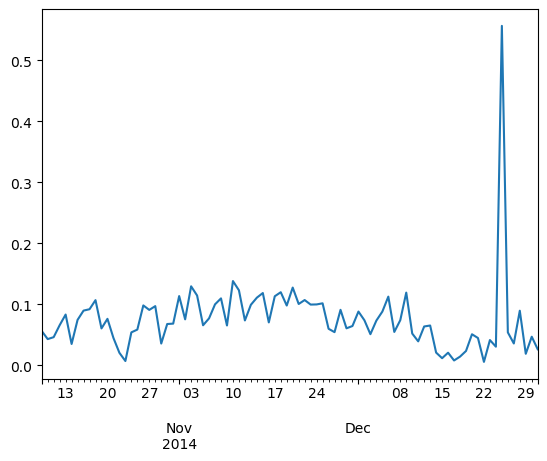

In [272]:
overall[0].MAPE.plot()

In [273]:
overall[0].MAPE.mean()

0.07646721251028889

In [274]:
overall[1].MAPE.mean()

0.16124250337486412

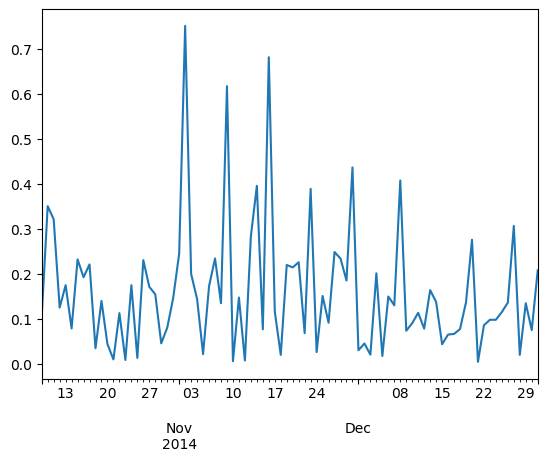

In [275]:
overall[1].MAPE.plot()

In [282]:
FMAPE = overall[0]['MAPE'] * 8/370 + overall[1]['MAPE']* 2/370 + overall[2]['MAPE'] * 121/370 + overall[3]['MAPE'] * 16/370 +overall[4]['MAPE'] * 141/370 + overall[5]['MAPE'] * 3/370 + overall[6]['MAPE'] * 2/370 + overall[7]['MAPE'] * 15/370 + overall[8]['MAPE'] * 3/370 + overall[9]['MAPE'] * 6/370 + overall[10]['MAPE'] * 7/370 + overall[11]['MAPE'] * 34/370 + overall[12]['MAPE'] * 6/370 + overall[13]['MAPE']* 6/370  

In [283]:
FMAPE.mean()

0.08931150398980939

In [284]:
FMAPE = FMAPE.to_frame()

In [285]:
def label_time (row):
    if (row.name - FMAPE.index.min()).days < 28:
      return 1
    elif (row.name- FMAPE.index.min()).days < 56:
      return 2
    else:
      return 3

In [286]:
FMAPE['interval'] = FMAPE.apply (lambda row: label_time(row), axis = 1)

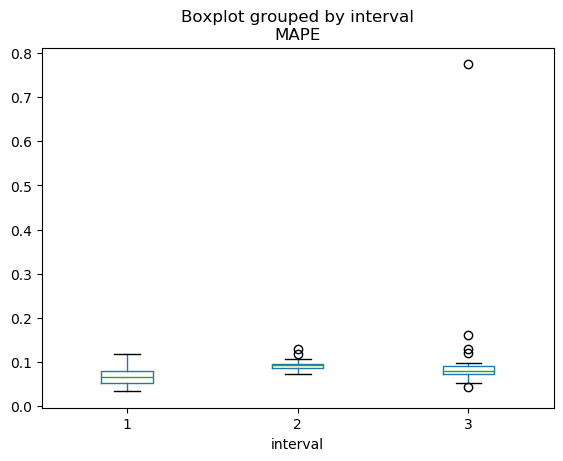

In [287]:
FMAPE.boxplot(by ='interval', column =['MAPE'], grid = False)

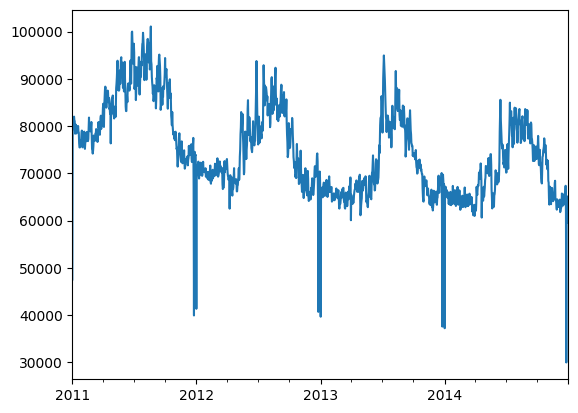

In [139]:
timeseries1[2].plot()

In [140]:
@interact_manual(
    customer_id=IntSlider(min=0, max=13, value=1, style=style),
    forecast_day=IntSlider(min=0, max=336, value=10, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_weeks_plot=IntSlider(min=1, max=10, value=1, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False,
)
def plot_interact(customer_id, forecast_day, confidence, show_samples):
    forecast_date = end_training + datetime.timedelta(days=forecast_day)
    ts = timeseries1[customer_id]
    freq = ts.index.freq
    target = ts[start_dataset : forecast_date + prediction_length * freq]
    dynamic_feat = [w['TAVG'].tolist()]
    plot(
        predictor_new_features,
        target_ts=target,
        dynamic_feat=dynamic_feat,
        forecast_date=forecast_date,
        show_samples=show_samples,
        plot_history=7 * 12,
        confidence=confidence,
    )

interactive(children=(IntSlider(value=1, description='customer_id', max=13, style=SliderStyle(description_widt…

In [87]:
# predictor.delete_model()
# predictor.delete_endpoint()

In [206]:
predictor_new_features.delete_model()
predictor_new_features.delete_endpoint()

INFO:sagemaker:Deleting model with name: deepar-electricity-demo-new-features-2023-06-08-22-42-22-899
INFO:sagemaker:Deleting endpoint configuration with name: deepar-electricity-demo-new-features-2023-06-08-22-42-22-899
INFO:sagemaker:Deleting endpoint with name: deepar-electricity-demo-new-features-2023-06-08-22-42-22-899
